# Hotel Revenue Forecasting

## Study
In France, there is a diverse range of hotels spread across various regions, catering to the needs of travelers and tourists alike. Within these hotels, there exist sub hotels or smaller lodging establishments that operate under the main hotel brand. The primary objective is to forecast the monthly revenue generated by each sub hotel to optimize financial planning and resource allocation.

To achieve this, we can employ data-driven approaches such as machine learning and statistical models that take into account factors like seasonal trends, location, sub hotel size, and customer demographics. By analyzing historical data and leveraging real-time information, we can develop predictive models that enable accurate revenue estimation for each sub hotel on a monthly basis.

**Data are private. Sorry !!**

**We want to predict the revenue monthly**

In [1]:
#Import libraries
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split



In [13]:
list_db = df_st.db_name.unique().tolist()

print(f' We have {len(list_db)} hotels ')

 We have 194 hotels 


### Features engineering

Now that we have gathered our data, we can begin the process of feature engineering, which involves selecting, transforming, and creating relevant variables to enhance the predictive power of our models. In this case, we will use longitude and latitude as features, as well as create additional variables representing holidays, seasonality, and trends to build a more robust forecasting model.

**Longitude and Latitude**: These geographical features will help capture the regional differences in revenue generation. By including them in our model, we can account for variations in subhotel performance due to their specific locations.

**Holidays**: The presence of national and local holidays can have a significant impact on hotel demand and, consequently, revenue. Creating a binary variable that indicates whether a particular day is a holiday or not will allow our model to consider the effect of holidays on subhotel revenue.

**Seasonality**: The demand for hotel accommodations often follows seasonal patterns. To capture these fluctuations, we can create categorical variables representing different seasons (e.g., spring, summer, fall, and winter) or incorporate sine and cosine functions with annual and semi-annual frequencies to model the cyclical nature of seasonality.

**Trend**: To account for the underlying growth or decline in the hotel industry over time, we can create a trend variable that represents the passage of time. This can be as simple as a continuous integer variable counting the months, or more sophisticated approaches such as decomposing time series data into trend, seasonal, and residual components using techniques like the Hodrick-Prescott filter or exponential smoothing.

By incorporating these features into our model, we can better understand the various factors that contribute to the monthly revenue of each subhotel. This improved understanding will enable us to make more accurate predictions, leading to better decision-making and resource allocation for the hotels and their subhotels in France.


For Holidays, i will use vacances-scolaires-france.csv **source** : *https://github.com/AntoineAugusti/vacances-scolaires-france/blob/master/vacances_scolaires_france/data/data.csv*



In [24]:
#France's holidays school data
df_vac = pd.read_excel('vacances-scolaires.xlsx')
df_vac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12418 entries, 0 to 12417
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             12418 non-null  datetime64[ns]
 1   vacances_zone_a  12418 non-null  bool          
 2   vacances_zone_b  12418 non-null  bool          
 3   vacances_zone_c  12418 non-null  bool          
 4   nom_vacances     4972 non-null   object        
dtypes: bool(3), datetime64[ns](1), object(1)
memory usage: 230.5+ KB


In [25]:
# France's days off data
df_ferier = pd.read_csv('jours_feries_metropole.csv')
df_ferier['date'] = pd.to_datetime(df_ferier.date)
df_ferier.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            286 non-null    datetime64[ns]
 1   annee           286 non-null    int64         
 2   zone            286 non-null    object        
 3   nom_jour_ferie  286 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 9.1+ KB


In [26]:
#merge all holidays
df_holidays = df_vac.merge(df_ferier, how='outer', on='date')
df_holidays

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances,annee,zone,nom_jour_ferie
0,1990-01-01,False,False,False,NaN,NaN,NaN,NaN
1,1990-01-02,False,False,False,NaN,NaN,NaN,NaN
2,1990-01-03,False,False,False,NaN,NaN,NaN,NaN
3,1990-01-04,False,False,False,NaN,NaN,NaN,NaN
4,1990-01-05,False,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12469,2028-07-14,NaN,NaN,NaN,NaN,2028.0,Métropole,14 juillet
12470,2028-08-15,NaN,NaN,NaN,NaN,2028.0,Métropole,Assomption
12471,2028-11-01,NaN,NaN,NaN,NaN,2028.0,Métropole,Toussaint
12472,2028-11-11,NaN,NaN,NaN,NaN,2028.0,Métropole,11 novembre


In [17]:
#Took one hotel as an example
df_roch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   roi_id                   2247 non-null   int64  
 1   roi_date                 2247 non-null   object 
 2   ttc                      2247 non-null   float64
 3   roi_ref                  2247 non-null   object 
 4   tv                       2247 non-null   int64  
 5   source_type              2247 non-null   int64  
 6   ref_com                  2247 non-null   int64  
 7   algo_id                  2247 non-null   int64  
 8   libelle                  2247 non-null   object 
 9   subsite_id               2247 non-null   int64  
 10  type                     2247 non-null   int64  
 11  roi_qualificationClient  2247 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 210.8+ KB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


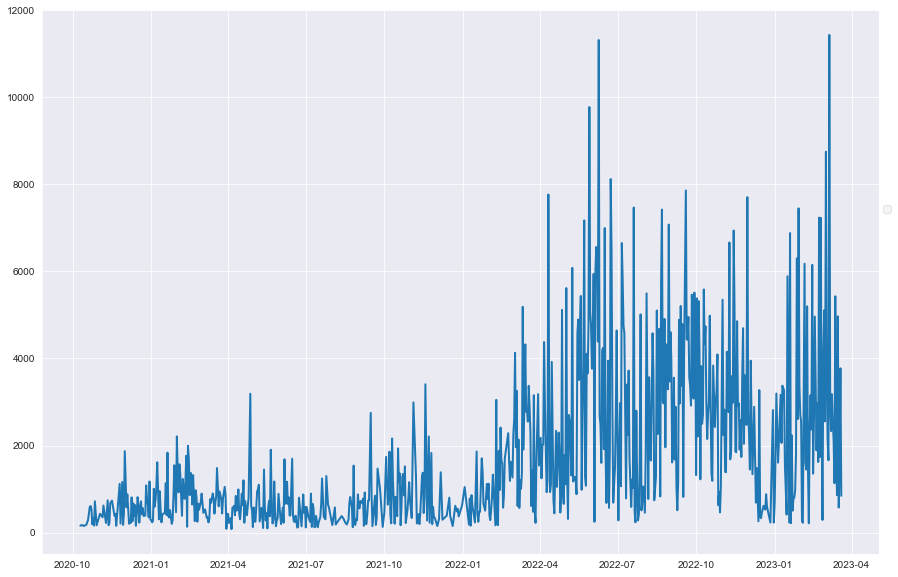

In [7]:
import matplotlib.pyplot as plt
temp = df_roch.groupby(['roi_date']
                      )['ttc'].sum().reset_index()
plt.figure(figsize=(15, 10))


plt.plot(temp['roi_date'], temp['ttc'], linewidth=2)

leg = plt.legend(ncol=1, bbox_to_anchor=(1.02, .65))
leg.get_frame().set_alpha(0.5)


plt.show()

In [27]:
df_roch= pd.merge(df_roch, df_st, left_on='subsite_id', right_on='ids')
df_roch['date'] = pd.to_datetime(df_roch.roi_date)


In [28]:
temp = df_roch[(df_roch['site_code'] == '9414') & (df_roch['date'] <= '2022-12-31') ]

In [29]:
# Merge the hotel_data with holiday_data
df_roch['date'] = pd.to_datetime(df_roch.roi_date)
hotel_data = temp.merge(df_holidays, on='date', how='left')
hotel_data['vacances_zone_a'] = hotel_data['vacances_zone_a'].astype(int)
hotel_data['vacances_zone_b'] = hotel_data['vacances_zone_b'].astype(int)
hotel_data['vacances_zone_c'] = hotel_data['vacances_zone_c'].astype(int)
hotel_data['is_day_off'] = (hotel_data['nom_jour_ferie'].notnull()).astype(int)


### Seasonnality

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

def identify_seasonality(df):
    """

    :param df:
    :return:
    """
    # Fetch data and preprocess it
    df['roi_date'] = pd.to_datetime(df.roi_date)

    # Aggregate data to monthly
    df['month'] = df['roi_date'].dt.to_period('M')
    data = df.groupby('month').agg({'ttc': 'sum'}).reset_index()

    # Set seasonal periods
    weekly_period = 52
    yearly_period = 12

    # Initialize variables to store seasonal components
    avg_seasonal_weekly = 0
    avg_seasonal_yearly = 0

    # Decompose the time series for both seasonal periods if the data is long enough
    if len(data) >= 2 * yearly_period:
        result_yearly = seasonal_decompose(data['ttc'], model='additive', period=yearly_period, extrapolate_trend='freq')
        avg_seasonal_yearly = np.abs(result_yearly.seasonal).mean()

    if len(data) >= 2 * weekly_period:
        result_weekly = seasonal_decompose(data['ttc'], model='additive', period=weekly_period, extrapolate_trend='freq')
        avg_seasonal_weekly = np.abs(result_weekly.seasonal).mean()

    # Set a threshold for determining seasonality
    threshold = 0.2

    is_weekly_seasonal = avg_seasonal_weekly > threshold
    is_yearly_seasonal = avg_seasonal_yearly > threshold

    # Return identified seasonality
    if is_weekly_seasonal and is_yearly_seasonal:
        return "both"
    elif is_weekly_seasonal:
        return "weekly"
    elif is_yearly_seasonal:
        return "yearly"
    else:
        return "none"

# Analyze seasonality for each hotel and store the results
seasonality_results = {}
"""for scode in hotel_site_code:
    temp = df_hotel[df_hotel['site_code'] == scode]
    seasonality = identify_seasonality(temp)
    seasonality_results[scode] = seasonality"""



"for scode in hotel_site_code:\n    temp = df_hotel[df_hotel['site_code'] == scode]\n    seasonality = identify_seasonality(temp)\n    seasonality_results[scode] = seasonality"

In [32]:
identify_seasonality(hotel_data)
hotel_data['seasonnality'] = identify_seasonality(hotel_data)


In [36]:
# Aggregate hotel_data to monthly level
hotel_data['month'] = hotel_data['date'].dt.to_period('M')
monthly_data = hotel_data.groupby('month').agg({'ttc': 'sum', 'roi_ref' : 'count','vacances_zone_a': 'sum', 'vacances_zone_b': 'sum',
                                                'vacances_zone_c': 'sum', 'is_day_off': 'sum',
                                                'longitude' : 'first',  'latitude' : 'first', 'seasonnality' : 'first'}).reset_index()
monthly_data.drop(['longitude', 'latitude'], axis= 1)

,month,ttc,roi_ref,vacances_zone_a,vacances_zone_b,vacances_zone_c,is_day_off,seasonnality
0,2020-10,4681.78,38,35,35,35,0,yearly
1,2020-11,8234.62,37,0,0,0,3,yearly
2,2020-12,16326.61,66,29,29,29,1,yearly
3,2021-01,19287.24,76,3,3,3,1,yearly
4,2021-02,25769.54,88,52,17,48,0,yearly
5,2021-03,15638.46,62,0,9,0,0,yearly
6,2021-04,17611.60,61,39,12,28,1,yearly
7,2021-05,16335.68,66,14,29,17,10,yearly
8,2021-06,15777.84,68,0,0,0,0,yearly
9,2021-07,10361.16,37,32,32,32,0,yearly


### LightGBM

In [37]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Convert month to datetime and extract features
monthly_data['month'] = pd.to_datetime(monthly_data['month'].astype(str))
monthly_data['month_number'] = monthly_data['month'].dt.month
monthly_data['year'] = monthly_data['month'].dt.year
monthly_data['latitude'] = monthly_data['latitude'].replace('', np.nan).astype(float)
monthly_data['longitude'] = monthly_data['longitude'].replace('', np.nan).astype(float)
# Train-test split
train_data, test_data = train_test_split(monthly_data, test_size=0.2, random_state=42)

# Prepare the dataset for LightGBM
train_dataset = lgb.Dataset(train_data[['year', 'month_number', 'roi_ref', 'vacances_zone_a','vacances_zone_b',
                                        'vacances_zone_c', 'is_day_off', 'longitude', 'latitude']], label=train_data['ttc'])
test_dataset = lgb.Dataset(test_data[['year', 'month_number', 'roi_ref', 'vacances_zone_a','vacances_zone_b',
                                      'vacances_zone_c', 'is_day_off', 'longitude', 'latitude']], label=test_data['ttc'])

# Set model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the LightGBM model
model = lgb.train(params, train_dataset, num_boost_round=5000, valid_sets=test_dataset, early_stopping_rounds=100)

# Predict on the test set
y_pred = model.predict(test_data[['year', 'month_number', 'roi_ref', 'vacances_zone_a','vacances_zone_b',
                                  'vacances_zone_c', 'is_day_off', 'longitude', 'latitude']])

# Calculate evaluation metrics
mse = mean_squared_error(test_data['ttc'], y_pred)
mae = mean_absolute_error(test_data['ttc'], y_pred)
r2 = r2_score(test_data['ttc'], y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's rmse: 71130.8
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's rmse: 71130.8
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's rmse: 71130.8
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[4]	valid_0's rmse: 71130.8
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[5]	valid_0's rmse: 71130.8
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[6]	valid_0's rmse: 71130.8
[LightGBM] [Warning] Stopped training because there are

C:\Users\Mohamed\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


It seems like the model stopped training after the first iteration, which suggests that the model is not learning effectively from the data. The negative R² score indicates that the model does not perform well in predicting the revenue. Maybe the problem that we don't have enough data. Let's try other simpler algorithms

In [38]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert month to datetime and extract features
monthly_data['month'] = pd.to_datetime(monthly_data['month'].astype(str))
monthly_data['month_number'] = monthly_data['month'].dt.month
monthly_data['year'] = monthly_data['month'].dt.year
monthly_data['latitude'] = monthly_data['latitude'].replace('', np.nan).astype(float)
monthly_data['longitude'] = monthly_data['longitude'].replace('', np.nan).astype(float)




# Prepare the dataset
X = monthly_data[['year', 'month_number', 'roi_ref', 'vacances_zone_a','vacances_zone_b',
                  'vacances_zone_c', 'is_day_off', 'longitude', 'latitude']]
y = monthly_data['ttc']
# Create a Linear Regression model
model = LinearRegression()

# Set up cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate evaluation metrics
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in k_fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# Calculate average evaluation metrics
mse_mean = np.mean(mse_scores)
mae_mean = np.mean(mae_scores)
r2_mean = np.mean(r2_scores)

print(f"Mean Squared Error: {mse_mean}")
print(f"Mean Absolute Error: {mae_mean}")
print(f"R² Score: {r2_mean}")

Mean Squared Error: 249906001.86619106
Mean Absolute Error: 12398.602432618434
R² Score: 0.7290178286336764


Based on the evaluation metrics, the Linear Regression model with k-fold cross-validation seems to have performed better than the previous model:

Mean Squared Error (MSE) has decreased from 42410839.6 to 249906001.87, indicating a lower average squared error between the predicted and actual values.
Mean Absolute Error (MAE) has also decreased from 5713.83 to 12398.60, suggesting that, on average, the model's predictions are closer to the actual values.
The R² score has improved from -0.0621 to 0.7290, showing that the model explains approximately 72.9% of the variance in the revenue data.


The improvement in performance can be attributed to the use of a simpler model (Linear Regression) and k-fold cross-validation, which helps to make better use of the limited data available.

We can pass now to **Decision Tree** and **Random Forest**

In [70]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# Convert month to datetime and extract features
monthly_data['month'] = pd.to_datetime(monthly_data['month'].astype(str))
monthly_data['month_number'] = monthly_data['month'].dt.month
monthly_data['year'] = monthly_data['month'].dt.year
monthly_data['latitude'] = monthly_data['latitude'].replace('', np.nan).astype(float)
monthly_data['longitude'] = monthly_data['longitude'].replace('', np.nan).astype(float)




# Prepare the dataset
X = monthly_data[['year', 'month_number', 'roi_ref', 'vacances_zone_a','vacances_zone_b',
                  'vacances_zone_c', 'is_day_off', 'longitude', 'latitude']]
y = monthly_data['ttc']

# Create models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Set up cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate evaluation metrics
for model_name, model in models.items():
    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    # Calculate average evaluation metrics
    mse_mean = np.mean(mse_scores)
    mae_mean = np.mean(mae_scores)
    r2_mean = np.mean(r2_scores)

    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {mse_mean}")
    print(f"Mean Absolute Error: {mae_mean}")
    print(f"R² Score: {r2_mean}")
    print("\n")


Model: Random Forest
Mean Squared Error: 270647242.92124796
Mean Absolute Error: 12789.015272
R² Score: 0.6789291503356967


Model: Decision Tree
Mean Squared Error: 541593998.4686867
Mean Absolute Error: 17456.572
R² Score: 0.32839793815648904




From these results, the Random Forest model performs better than the Decision Tree model in terms of both the Mean Squared Error and the R² Score. The Random Forest model explains approximately 67.89% of the variance in the revenue data, while the Decision Tree model explains only 32.84%. The Random Forest model also has a lower Mean Absolute Error compared to the Decision Tree model.


Considering the limited dataset, the performance of the Random Forest model is relatively better than that of the Decision Tree model. However, it is important to note that with only 27 rows of data, the model's performance might still be limited, and it is essential to set realistic expectations for the model's accuracy and generalization ability.

Still **Linear Regression is better**

now i will combined all hotels data

In [39]:
all_monthly_data = pd.DataFrame()
site_code_list = df_hotel.site_code.unique().tolist()

df_hotel['date'] = pd.to_datetime(df_hotel.roi_date)
for scode in site_code_list:
    temp = df_hotel[(df_hotel['site_code'] == scode) & (df_hotel['date'] <= '2022-12-31') ]
    # Merge the hotel_data with holiday_data
    hotel_d= temp.merge(df_holidays, on='date', how='left')
    hotel_d['vacances_zone_a'] = hotel_d['vacances_zone_a'].astype(int)
    hotel_d['vacances_zone_b'] = hotel_d['vacances_zone_b'].astype(int)
    hotel_d['vacances_zone_c'] = hotel_d['vacances_zone_c'].astype(int)
    hotel_d['is_day_off'] = (hotel_d['nom_jour_ferie'].notnull()).astype(int)
# Aggregate hotel_data to monthly level
    hotel_d['month'] = hotel_d['date'].dt.to_period('M')
    monthly_data = hotel_d.groupby('month').agg({'ttc': 'sum', 'roi_ref' : 'count','vacances_zone_a': 'sum', 'vacances_zone_b': 'sum',
                                                    'vacances_zone_c': 'sum', 'is_day_off': 'sum',
                                                    'longitude' : 'first',  'latitude' : 'first'}).reset_index()
    monthly_data['site_code'] = scode
    all_monthly_data = pd.concat([all_monthly_data, monthly_data],  ignore_index=True)



In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert month to datetime and extract features
all_monthly_data['month'] = pd.to_datetime(all_monthly_data['month'].astype(str))
all_monthly_data['month_number'] = all_monthly_data['month'].dt.month
all_monthly_data['year'] = all_monthly_data['month'].dt.year
all_monthly_data['latitude'] = all_monthly_data['latitude'].replace('', np.nan).astype(float)
all_monthly_data['longitude'] = all_monthly_data['longitude'].replace('', np.nan).astype(float)
all_monthly_data = all_monthly_data.dropna()
# Prepare your data (replace 'combined_data' with your DataFrame)
X = all_monthly_data[['year', 'month_number', 'roi_ref', 'vacances_zone_a','vacances_zone_b',
                      'vacances_zone_c', 'is_day_off', 'longitude', 'latitude']]

y = all_monthly_data['ttc']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')


Mean Squared Error: 2579957566.1431727
Mean Absolute Error: 42664.656983070265
R² Score: -10.558218381222476


The results  obtained after combining the data show a high Mean Squared Error (MSE), a relatively low R² score, and a reasonable Mean Absolute Error (MAE). These results indicate that the current model might not be able to capture the relationships between the features and the target variable (revenue) effectively.

Seems that aggregate data monthly and do the prediction not working well. I will deal with data daily and then aggregate the predictions to get the monthly.  This approach can be beneficial when you have more daily data available, and it can capture daily patterns that might be lost when aggregating to monthly data.

### DAILY DATA

In [41]:
df_roch= pd.merge(df_roch, df_st, left_on='subsite_id', right_on='ids')
df_roch['date'] = pd.to_datetime(df_roch.roi_date)

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_19664\1562647140.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'pms_id_x', 'url_x', 'longitude_x', 'enabled_x', 'pr_id_x', 'Login_x', 'SiteName_x', 'latitude_x', 'ids_x', 'db_name_x', 'site_code_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_roch= pd.merge(df_roch, df_st, left_on='subsite_id', right_on='ids')


In [44]:

daily_data = hotel_data.groupby('date').agg({'ttc': 'sum', 'roi_ref' : 'count','vacances_zone_a': 'first', 'vacances_zone_b': 'first',
                                                'vacances_zone_c': 'first', 'is_day_off': 'first',
                                                'longitude' : 'first',  'latitude' : 'first'}).reset_index()
daily_data.drop(['longitude', 'latitude'], axis= 1)

,date,ttc,roi_ref,vacances_zone_a,vacances_zone_b,vacances_zone_c,is_day_off
0,2020-10-10,159.22,1,0,0,0,0
1,2020-10-12,174.88,1,0,0,0,0
2,2020-10-14,151.12,1,0,0,0,0
3,2020-10-17,180.00,2,1,1,1,0
4,2020-10-19,290.00,4,1,1,1,0
...,...,...,...,...,...,...,...
668,2022-12-23,594.00,1,1,1,1,0
669,2022-12-27,230.00,1,1,1,1,0
670,2022-12-29,1939.00,2,1,1,1,0
671,2022-12-30,2814.00,3,1,1,1,0


In [45]:
# Create Date-related Features to be used for EDA and Supervised ML: Regression
daily_data['annee'] = daily_data['date'].dt.year
daily_data['mois'] = daily_data['date'].dt.month
daily_data['jour'] = daily_data['date'].dt.day
daily_data['weekday'] = daily_data['date'].dt.dayofweek
daily_data['is_weekend'] = daily_data['date'].apply(lambda x: x.weekday() in [5, 6]).astype(int)




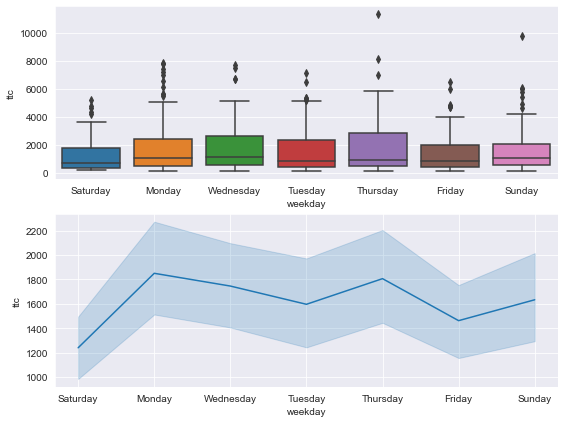

In [131]:
import seaborn as sn
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='weekday', y='ttc', data=daily_data, ax=axs[0])
_ = sn.lineplot(x='weekday', y='ttc', data=daily_data, ax=axs[1])

After seeing this plot we can deduce that weekday has some impact on revenue. Let's add it on our model

In [46]:
average_revenue_per_weekday = daily_data.groupby('weekday')['ttc'].mean()
total_average_revenue = average_revenue_per_weekday.sum()
weekday_weights = average_revenue_per_weekday / total_average_revenue
weekday_weights

weekday
0    0.163266
1    0.140835
2    0.154039
3    0.159389
4    0.128995
5    0.109364
6    0.144111
Name: ttc, dtype: float64

In [47]:
daily_data['weekday_weight'] = daily_data['weekday'].map(weekday_weights)


In [48]:
daily_data['N-1'] = daily_data.groupby([daily_data['date'].dt.month,daily_data['date'].dt.day])['ttc'].shift()
daily_data.drop(['longitude', 'latitude'], axis = 1)

,date,ttc,roi_ref,vacances_zone_a,vacances_zone_b,vacances_zone_c,is_day_off,annee,mois,jour,weekday,is_weekend,weekday_weight,N-1
0,2020-10-10,159.22,1,0,0,0,0,2020,10,10,5,1,0.109364,NaN
1,2020-10-12,174.88,1,0,0,0,0,2020,10,12,0,0,0.163266,NaN
2,2020-10-14,151.12,1,0,0,0,0,2020,10,14,2,0,0.154039,NaN
3,2020-10-17,180.00,2,1,1,1,0,2020,10,17,5,1,0.109364,NaN
4,2020-10-19,290.00,4,1,1,1,0,2020,10,19,0,0,0.163266,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,2022-12-23,594.00,1,1,1,1,0,2022,12,23,4,0,0.128995,616.80
669,2022-12-27,230.00,1,1,1,1,0,2022,12,27,1,0,0.140835,369.96
670,2022-12-29,1939.00,2,1,1,1,0,2022,12,29,3,0,0.159389,350.57
671,2022-12-30,2814.00,3,1,1,1,0,2022,12,30,4,0,0.128995,1173.01


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


df = daily_data.dropna()

# Prepare your data (assuming 'daily_data' is your DataFrame with the 'weekday_weight' feature)
X = df.drop(['weekday'], axis=1)  # Drop 'date' as it's not needed for the model
y = df['ttc']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_tr = X_train.drop(['ttc', 'date'], axis=1)
X_te = X_test.drop(['ttc', 'date'], axis=1)
# Train the model (e.g., Linear Regression)
model = LinearRegression()
model.fit(X_tr, y_train)
# Make predictions
y_pred = model.predict(X_te)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')


Mean Squared Error: 865424.749318744
Mean Absolute Error: 753.1918219915046
R² Score: 0.6246004952543438


It seems that we still have R² score between 70% and 60%. We should try another solution like feature engineering or some other variables interesting like weather for example. (let's keep it for another day 😉

